# BE Anomaly Detection
#### Michta Emmanuel - Louvet Matthieu - Blanc Axel

Les données sont brutes, et contiennent a priori des anomalies. Nous utiliserons des techniques de Outlier Detection et non de Novelty Detection, vu que nous n'avons pas de dataset propre (cad sans anomalie).

Nous n'avons pas de description du système physique, ni de description précise d'une anomalie (par exemple, un seuil d'admissibilité des valeurs pour les capteurs). Par conséquent, notre travail a reposé sur la définition d'une anomalie, à partir des données, et s'approche par conséquent plus ou moins de la réalité physique d'une anomalie. 

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from itertools import cycle
%matplotlib inline

### Part 1: Data observation and preparation

In [91]:
df = pd.read_csv("dataset.csv")
df.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000
mean,0.000009,0.000011,0.000031,0.000005,0.000016,-0.000005,-0.000002,0.000003,-0.000021,0.000026,0.000030
std,0.999950,0.999925,0.999961,0.999925,0.999963,0.999926,0.999950,0.999949,0.997770,0.999686,0.999847
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-12.044778,-3.183571
25%,-0.678808,-0.482716,-0.629123,-0.491585,-0.612334,-0.559023,-0.606135,-0.736398,-0.593096,-0.498480,-0.658530
50%,0.041883,0.180360,0.041442,0.147397,0.117040,0.153972,0.186038,-0.012354,-0.034882,-0.257635,-0.015437
75%,0.743973,0.656920,0.659246,0.636887,0.712393,0.685353,0.718237,0.802395,0.508232,0.359773,0.636740
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


In [92]:
#sns_plot = sns.pairplot(df[:8000],hue='day_cycle_window',  height=2.5);
#sns_plot.savefig("repartitions.png")

In [93]:
day_cycle_window = df['day_cycle_window']
df = df.drop(['day_cycle_window'], axis=1)

In [34]:
print('Les distributions sont centrées et réduites: \n')
print('Means:\n', df.mean(), '\n')
print('Std: \n', df.std())

Les distributions sont centrées et réduites: 

Means:
 p1     0.000009
p2     0.000011
p3     0.000031
p4     0.000005
p5     0.000016
p6    -0.000005
p7    -0.000002
p8     0.000003
p9    -0.000021
p10    0.000026
p11    0.000030
dtype: float64 

Std: 
 p1     0.999950
p2     0.999925
p3     0.999961
p4     0.999925
p5     0.999963
p6     0.999926
p7     0.999950
p8     0.999949
p9     0.997770
p10    0.999686
p11    0.999847
dtype: float64



 Certains points sont éloignés d une distribution normale des données: 



/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


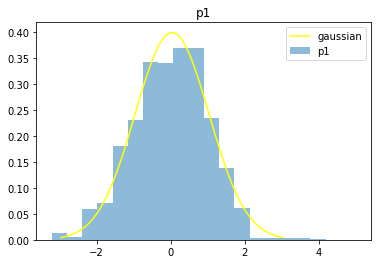

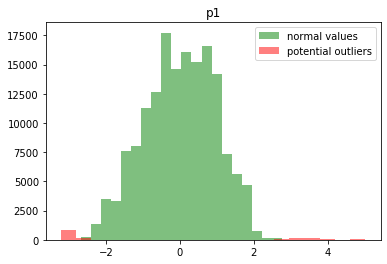

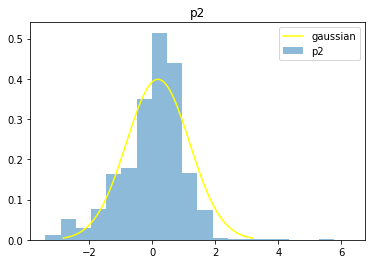

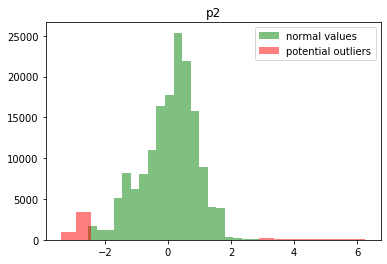

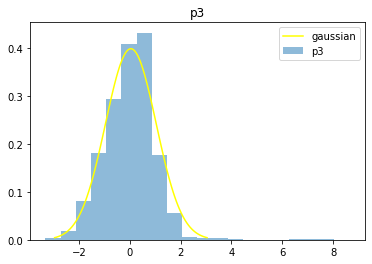

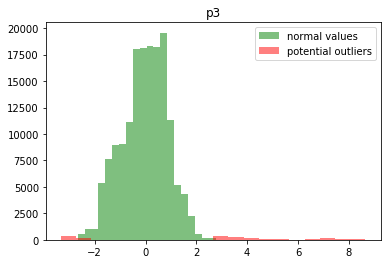

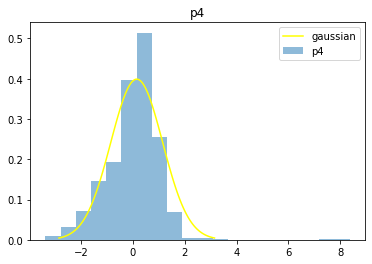

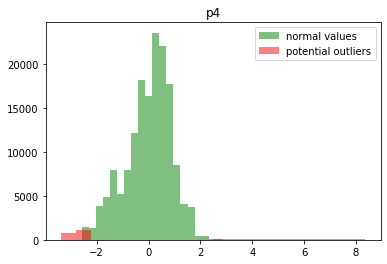

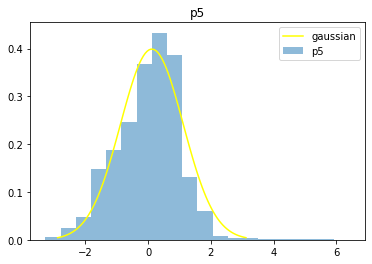

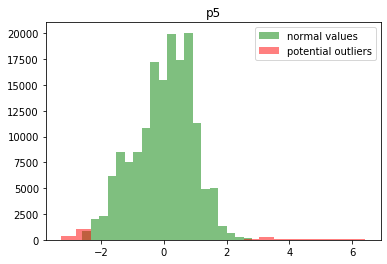

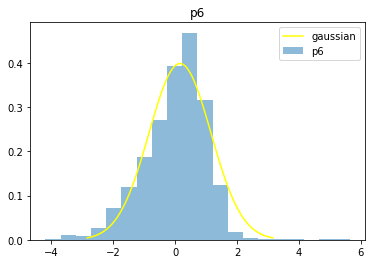

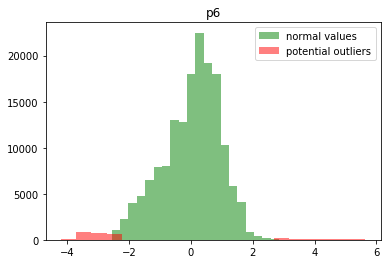

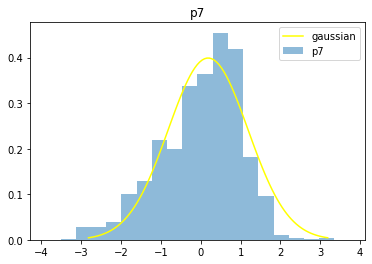

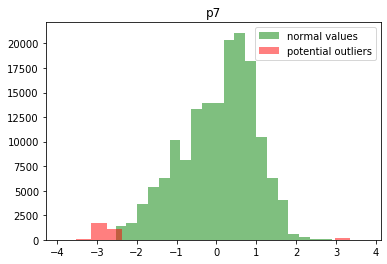

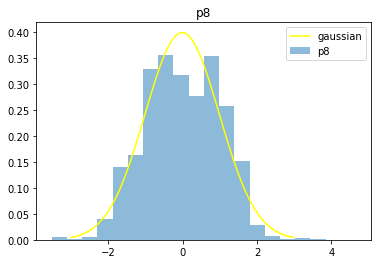

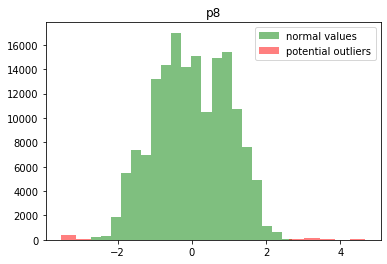

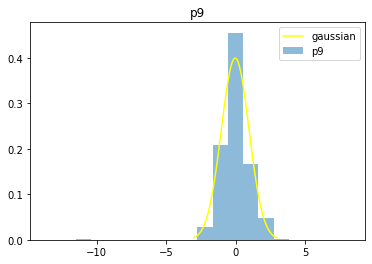

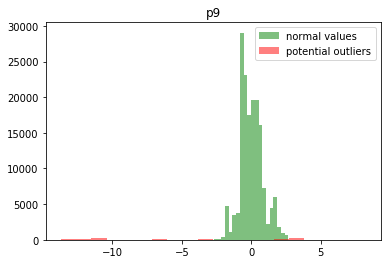

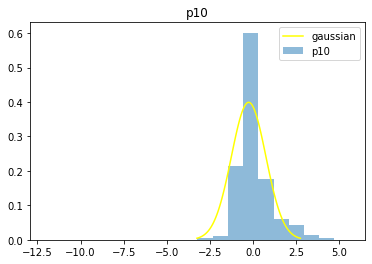

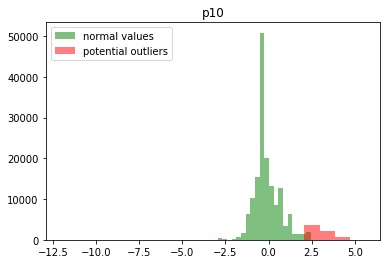

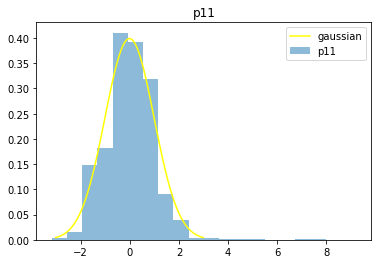

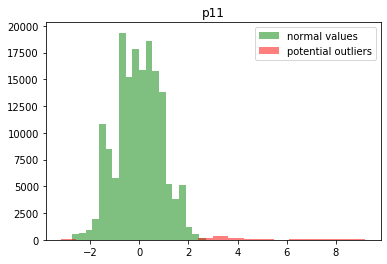

In [6]:
print('\n Certains points sont éloignés d une distribution normale des données: \n')
for col in df.columns.unique():
    m = df[col].median()
    s = df[col].std()
    x = np.linspace(m - 3*s, m + 3*s, 100)
    gaussian = stats.norm.pdf(x, m, s)

    ins = df[stats.norm.pdf(df[col], m, s)>0.01];
    outs = df[stats.norm.pdf(df[col], m, s)<0.01];

    plt.figure()
    l = plt.hist(df[col], density=True, bins = 20, alpha=0.5, label = col)
    plt.plot(x, gaussian, color = 'yellow', label = 'gaussian')
    plt.legend()
    plt.title(col)

    plt.figure()
    plt.hist(df[col],density=True, alpha=0.5)
    plt.hist(ins[col],  alpha=0.5,color='green',bins=20,label='normal values')
    plt.hist(outs[col], alpha=0.5, color='red', bins=20, label='potential outliers')
    plt.legend()
    plt.title(col)
    

In [95]:
#### Groupement du dataframe par window en prenant la moyenne ####
df2 = pd.read_csv("dataset.csv")
df_by_window = df2.groupby("day_cycle_window", sort=False).mean()

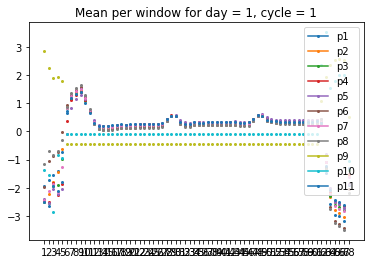

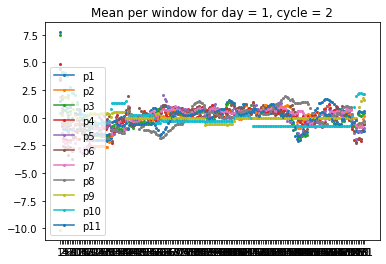

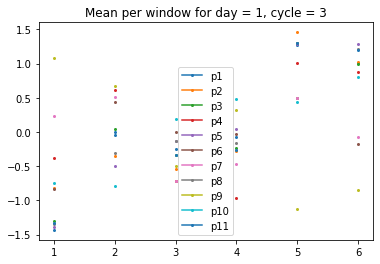

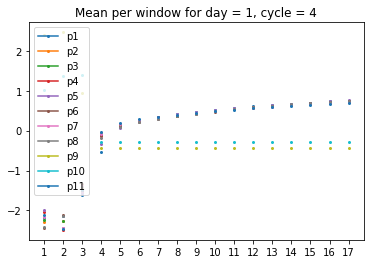

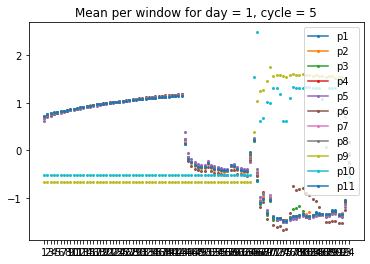

In [96]:
#### Print des valeurs par window pour le jour 1 et les cycles de 1 à 5 ####

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
prop_cycle = plt.rcParams['axes.prop_cycle']

i=0
nb_cycle_day = 5
for c in range(nb_cycle_day) :
    fig, ax = plt.subplots()
    while df_by_window.index[i][2] == str(c+1) :
        colour_codes = map('C{}'.format, cycle(range(len(df_by_window.columns)+1)))
        for column in df_by_window.columns :
            colour_code = next(colour_codes)
            plt.plot(df_by_window.index[i][4:], df_by_window[column][i], colour_code, markersize=2, marker='o', label=column)
        i = i + 1
    plt.title("Mean per window for day = {}, cycle = {}".format(df_by_window.index[i-1][0], df_by_window.index[i-1][2]))
    legend_without_duplicate_labels(ax)
    plt.show()

## Part 2: Prediction

Nous allons ici essayer de détecter les points qui sont des outliers. Les windows qui contiennent le plus grand nombre de tels points seront alors considérées comme outliers.



On choisit ici:
- Contamination = 15%, ce qui signifie que nos classifiers cherchent 15% d'outliers. Cependant, comme nous allons utiliser ces résultats pour détecter les windows outlier, cela ne signifie pas qu'il y aura 15% de windows outliers


Et comme classifiers: 
- Elliptic Enveloppe, qui nous permettra d'éloigner les valeurs s'éloignant d'une répartition gaussienne des données
- Isolation Forest, pour éviter le swamping et le masking
- LOF, qui nous permettra aussi de trouver de trouver les points proches de clusters denses (locality aspect)

In [35]:
def plotAnomalyScore2D_bis(df, clf_name, clf, f1, f2):
    """
        Same as plotAnomalyScore2D, but with a classifier trained on the whole dataset
        - df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        - clf_name: String value - name of the outlier detection model
        - clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df)
    
    plt.figure()
    sc = plt.scatter(x=df[f1],y=df[f2], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(clf_name)

In [36]:
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.15)
isf.fit(df)

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.15)
lof.fit(df)

cov = EllipticEnvelope(random_state=0)
cov.fit(df)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=0,
                 store_precision=True, support_fraction=None)

In [ ]:
#Trop long
#ocsvm = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
#ocsvm.fit(df)

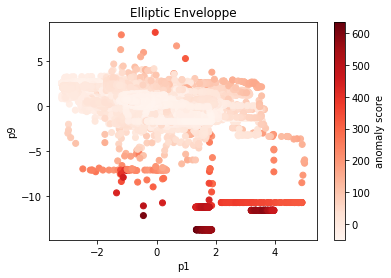

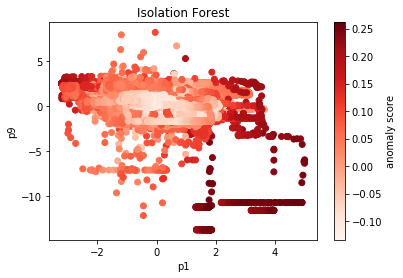

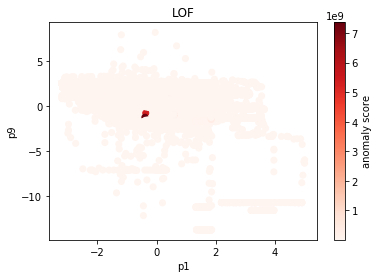

In [37]:
plotAnomalyScore2D_bis(df, 'Elliptic Enveloppe', cov, 'p1','p9')
plotAnomalyScore2D_bis(df, 'Isolation Forest', isf, 'p1','p9')
plotAnomalyScore2D_bis(df, 'LOF', lof, 'p1','p9')

#### Vision 1:

Si l'on souhaite considérer les scores de ces trois types d'anomalies, et créer un nouveau score en les combinant. Ici, un point est une anomalie si un des classifiers est très confiants, ou si plusieurs sont légèrements confiants. Certains points peuvent cependant être éliminés des outliers par effet de swamping ou masking

In [40]:
lof_score = lof.negative_outlier_factor_
isf_score = isf.decision_function(df)
cov_score = cov.decision_function(df)

In [41]:
print(lof_score)
print(isf_score)
print(cov_score)

[-0.96752156 -0.96752156 -0.99444759 ... -0.98086946 -1.43916958
 -3.37578775]
[0.02046894 0.02231798 0.02231798 ... 0.06688714 0.0693454  0.07151248]
[27.30509486 25.9325492  24.44174406 ... 38.00804851 38.29318691
 38.37519321]


In [42]:
print(lof_score.mean())
print(lof_score.std())
print(np.median(lof_score))
print('\n\n')
print(isf_score.mean())
print(isf_score.std())
print(np.median(isf_score))
print('\n\n')
print(cov_score.mean())
print(cov_score.std())
print(np.median(cov_score))

-1530125.0452684928
32211310.41526891
-1.0129270821342191



0.05985733727611034
0.057352823164541746
0.07483133201499645



28.22768269926735
33.35704049092159
36.51979643443047


In [89]:
#NORMALISER LES SCORES: VOIR DOC POUR SAVOIR A QUOI ILS CORRESPONDENT

In [43]:
anomaly_score = lof_score+isf_score+cov_score

#### Vision 2:

Si l'on considère qu'un point est une potentielle anomalie dès qu'un des classifiers l'a détecté comme tel, et que l'on souhaite sommer ces anomalies par windows:

In [44]:
anomaly_lof = lof.predict(df)
anomaly_cov = cov.predict(df)
anomaly_isf = isf.predict(df)
anomaly = (anomaly_lof+anomaly_cov+anomaly_isf == -1).astype(int)

AttributeError: predict is not available when novelty=False, use fit_predict if you want to predict on training data. Use novelty=True if you want to use LOF for novelty detection and predict on new unseen data.

In [45]:
df2 = df.copy()
df2['window']=day_cycle_window 
df2['anomaly']=anomaly
outliers_per_column = df2.groupby('window')['anomaly'].sum().sort_values(ascending = False)
outliers_per_column[:8]

NameError: name 'anomaly' is not defined

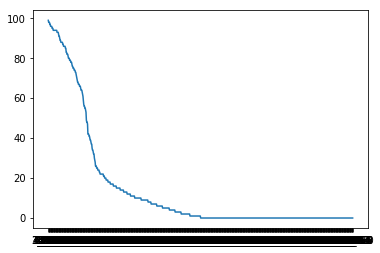

In [129]:
plt.plot(outliers_per_column[:800])

On remarque sur la figure ci-dessus que le nombre d'outliers par window décroit drastiquement sur les 200 premières windows de outliers_per_column. Nous pouvons donc supposer, selon cette vision, que les 200 premières windows sont les windows avec des anomalies. Cela représente 12% du dataset, ce qui n'est pas aberrant.

In [97]:
#### Agrandissement des plot figures ####
plt.rcParams['figure.figsize'] = [10, 5]

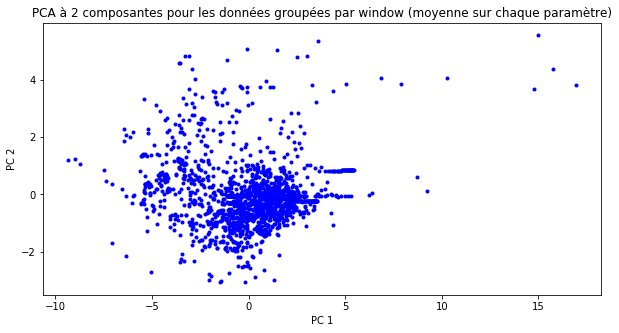

In [98]:
#### PCA à 2 composantes ####

pca = PCA(n_components=2)
pca.fit(df_by_window)
pca_by_window = pca.transform(df_by_window)
pca_by_window_df = pd.DataFrame(pca_by_window, columns = ['PC 1', 'PC 2'])
plt.plot(pca_by_window_df['PC 1'], pca_by_window_df['PC 2'], "b.")
plt.title("PCA à 2 composantes pour les données groupées par window (moyenne sur chaque paramètre)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [99]:
print("Variance expliquée pour 2 composantes = {:.2f} %".format(sum(pca.explained_variance_ratio_)*100))

Variance expliquée pour 2 composantes = 75.63 %


#### Algo sur les données regroupées par moyenne par window dans l'espace PCA à 2 composantes

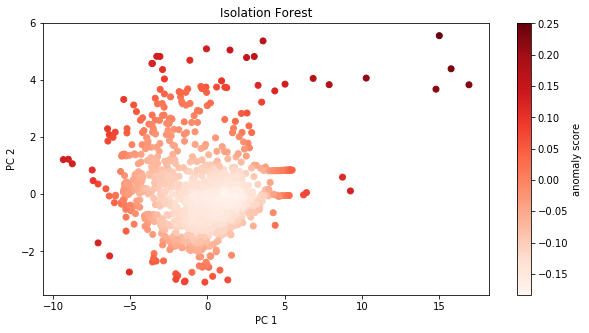

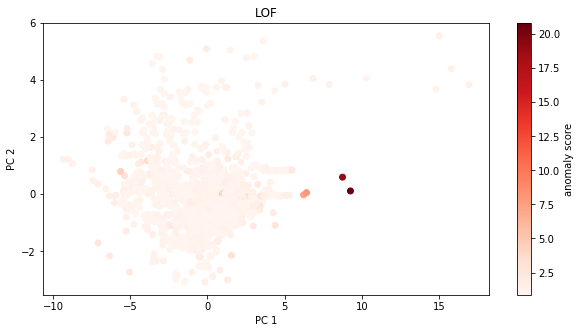

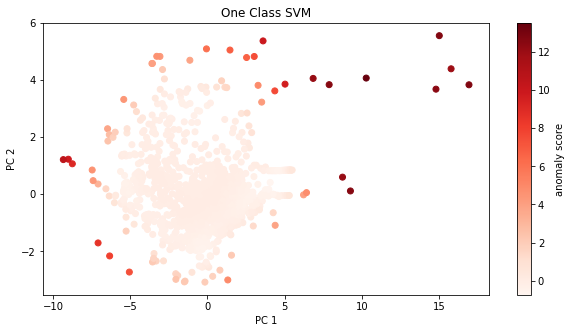

In [118]:
#### Algorithmes de détection d'anomalie appliqués aux données regroupées par moyenne 
#### de chaque window, avec PCA à 2 composantes ####

clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(pca_by_window_df[['PC 1','PC 2']])
plotAnomalyScore2D_bis(pca_by_window_df, clf_name, isf, 'PC 1','PC 2')

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(pca_by_window_df[['PC 1','PC 2']])
plotAnomalyScore2D_bis(pca_by_window_df, clf_name, lof, 'PC 1','PC 2')

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(pca_by_window_df[['PC 1','PC 2']])
plotAnomalyScore2D_bis(pca_by_window_df, clf_name, svm, 'PC 1','PC 2')

In [119]:
#### Anomaly score mis sur une échelle de 0 à 100 ####

lof_score = - lof.negative_outlier_factor_
isf_score = - isf.decision_function(pca_by_window_df)
svm_score = - svm.decision_function(pca_by_window_df)

lof_score = (lof_score-min(lof_score)) * 100 / (max(lof_score) - min(lof_score))
isf_score = (isf_score-min(isf_score)) * 100 / (max(isf_score) - min(isf_score))
svm_score = (svm_score-min(svm_score)) * 100 / (max(svm_score) - min(svm_score))

In [120]:
#### Total score / 100 : prise en compte des trois scores précédents ####

total_score = np.zeros(len(lof_score))
for i in range(len(lof_score)) :
    total_score[i] = (lof_score[i] + isf_score[i] + svm_score[i])/3

In [121]:
#### Liste des windows avec anomalie ####

threshold = 50 # Seuil au-dessus duquel une window est considérée comme anormale
outliers_index = np.where(total_score > threshold)
print("List of windows with anomaly : {} ".format(df_by_window.index.values[outliers_index]))
print("Nombre de windows anormales = {}".format(len(outliers_index[0])))
print("Contamination = {:.2f} %".format(len(outliers_index[0]) * 100 / df_by_window.shape[0]))

List of windows with anomaly : ['1_1_67' '1_2_1' '2_1_1' '2_2_76' '3_1_1' '3_2_51' '3_2_52' '4_1_16'
 '4_1_17' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 11
Contamination = 0.67 %


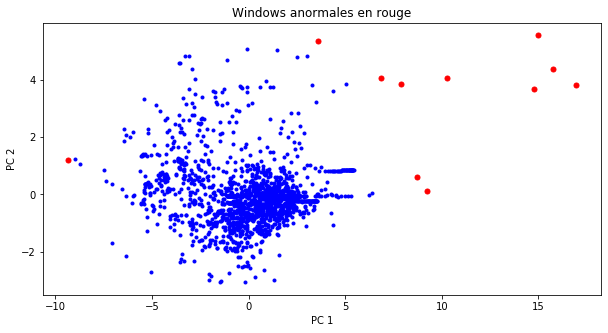

In [122]:
plt.plot(pca_by_window_df['PC 1'], pca_by_window_df['PC 2'], "b.")
plt.plot(pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 1'],
         pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Windows anormales en rouge")
plt.show()

#### Algo sur les données regroupées par moyenne par window sans PCA

In [123]:
#### Algorithmes de détection d'anomalie appliqués aux données regroupées par moyenne 
#### de chaque window, sans PCA ####

clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_by_window)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_by_window)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(df_by_window)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [124]:
#### Anomaly score mis sur une échelle de 0 à 100 ####

lof_score = - lof.negative_outlier_factor_
isf_score = - isf.decision_function(df_by_window)
svm_score = - svm.decision_function(df_by_window)

lof_score = (lof_score-min(lof_score)) * 100 / (max(lof_score) - min(lof_score))
isf_score = (isf_score-min(isf_score)) * 100 / (max(isf_score) - min(isf_score))
svm_score = (svm_score-min(svm_score)) * 100 / (max(svm_score) - min(svm_score))

#### Total score / 100 : prise en compte des trois scores précédents ####

total_score = np.zeros(len(lof_score))
for i in range(len(lof_score)) :
    total_score[i] = (lof_score[i] + isf_score[i] + svm_score[i])/3
    
#### Liste des windows avec anomalie ####

threshold = 50 # Seuil au-dessus duquel une window est considérée comme anormale
outliers_index = np.where(total_score > threshold)
print("List of windows with anomaly : {} ".format(df_by_window.index.values[outliers_index]))
print("Nombre de windows anormales = {}".format(len(outliers_index[0])))
print("Contamination = {:.2f} %".format(len(outliers_index[0]) * 100 / df_by_window.shape[0]))

List of windows with anomaly : ['1_1_66' '1_1_67' '1_2_1' '1_4_1' '2_1_1' '2_3_11' '2_3_145' '3_1_1'
 '3_2_51' '3_2_52' '4_1_16' '4_1_17' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 14
Contamination = 0.86 %


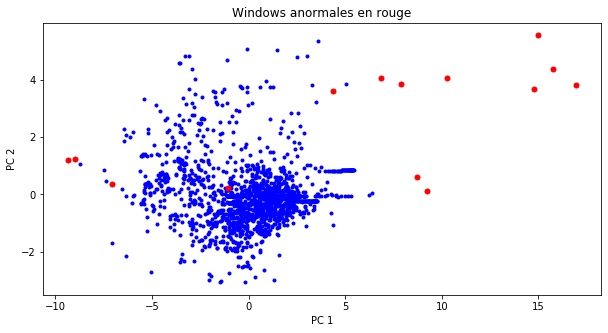

In [125]:
#### Visualisation des anomalies trouvées dans l'espace 2D de la PCA ####
plt.plot(pca_by_window_df['PC 1'], pca_by_window_df['PC 2'], "b.")
plt.plot(pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 1'],
         pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Windows anormales en rouge")
plt.show()

#### Algo sur les données regroupées par médiane par window sans PCA

In [126]:
#### Algorithmes de détection d'anomalie appliqués aux données regroupées par médiane 
#### de chaque window, sans PCA ####

df_by_window_med = df2.groupby("day_cycle_window", sort=False).median()

clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_by_window_med)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_by_window_med)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.3)
svm.fit(df_by_window_med)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [127]:
#### Anomaly score mis sur une échelle de 0 à 100 ####

lof_score = - lof.negative_outlier_factor_
isf_score = - isf.decision_function(df_by_window_med)
svm_score = - svm.decision_function(df_by_window_med)

lof_score = (lof_score-min(lof_score)) * 100 / (max(lof_score) - min(lof_score))
isf_score = (isf_score-min(isf_score)) * 100 / (max(isf_score) - min(isf_score))
svm_score = (svm_score-min(svm_score)) * 100 / (max(svm_score) - min(svm_score))

#### Total score / 100 : prise en compte des trois scores précédents ####

total_score = np.zeros(len(lof_score))
for i in range(len(lof_score)) :
    total_score[i] = (lof_score[i] + isf_score[i] + svm_score[i])/3
    
#### Liste des windows avec anomalie ####

threshold = 50 # Seuil au-dessus duquel une window est considérée comme anormale
outliers_index = np.where(total_score > threshold)
print("List of windows with anomaly : {} ".format(df_by_window_med.index.values[outliers_index]))
print("Nombre de windows anormales = {}".format(len(outliers_index[0])))
print("Contamination = {:.2f} %".format(len(outliers_index[0]) * 100 / df_by_window_med.shape[0]))

List of windows with anomaly : ['1_1_66' '1_1_67' '1_2_1' '2_1_1' '3_1_1' '3_2_51' '3_2_52' '4_1_16'
 '4_1_17' '4_2_1' '4_4_160'] 
Nombre de windows anormales = 11
Contamination = 0.67 %


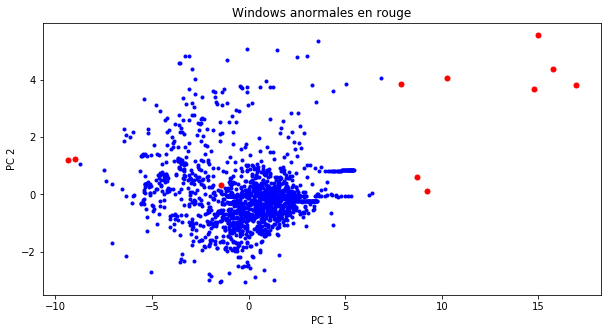

In [128]:
#### Visualisation des anomalies trouvées dans l'espace 2D de la PCA ####
plt.plot(pca_by_window_df['PC 1'], pca_by_window_df['PC 2'], "b.")
plt.plot(pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 1'],
         pca_by_window_df[np.isin(np.array(pca_by_window_df.index), outliers_index)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Windows anormales en rouge")
plt.show()

## Conclusion

Les windows anormales seraient donc, selon notre analyse,les éléments de outlier_windows. 

In [46]:
outlier_windows = outliers_per_column[:200].index
print('proportion of outliers: ', 200/len(outliers_per_column), '\n\n')
print('Outliers: \n\n', np.array(outlier_windows))

NameError: name 'outliers_per_column' is not defined